In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

from tensorflow import keras
from keras import layers


import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


2024-01-02 18:02:25.572106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 18:02:26.439561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ben/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
os.chdir('../')

In [3]:
os.getcwd()

'/home/ben/Repos/raspi-weather-station/analysis'

In [4]:
df = pd.read_csv('../saved_files/cleaned_ddb_output.csv'
        ).drop(columns=['Unnamed: 0']
        ).sort_values(by='timestamp')

Selecting only temperature data 

In [5]:
df.sort_values(by='timestamp', inplace=True)

In [6]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])

df_temp.set_index('timestamp',inplace=True)
df_temp.dropna(inplace=True)

In [7]:
# Split the data, 60% in training and 20% in validation, 20% in test, and not randomly selected since this is a time series

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.6))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.8))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
scaled_train = train_data / std

scaled_validation = (validation_data - mean)/std
scaled_test = (test_data - mean)/std


print(f'Mean of training data: {mean},'
      f'\nStandard deviation of training data: {std}')



Mean of training data: temperature    23.361925
dtype: float64,
Standard deviation of training data: temperature    1.972615
dtype: float64


Creating the generators. The task will be to take in one hour of readings, spaced 10 minutes apart, and predict the temperature in two hours. 

For example, there will be readings at 3:00pm, 3:10pm, ..., 4:00pm, and the task will be to predict the temperature at 6pm. 

In [8]:
delay = 24
sequence_length = 12

In [9]:
example_generator = keras.preprocessing.timeseries_dataset_from_array(np.arange(50)[:-delay], np.arange(50)[sequence_length+delay:],
    sequence_length=sequence_length, batch_size=1, shuffle=False)
    
for inputs, targets in example_generator:
    print(f'Input: {inputs}, targets: {targets}')

Input: [[ 0  1  2  3  4  5  6  7  8  9 10 11]], targets: [36]
Input: [[ 1  2  3  4  5  6  7  8  9 10 11 12]], targets: [37]
Input: [[ 2  3  4  5  6  7  8  9 10 11 12 13]], targets: [38]
Input: [[ 3  4  5  6  7  8  9 10 11 12 13 14]], targets: [39]
Input: [[ 4  5  6  7  8  9 10 11 12 13 14 15]], targets: [40]
Input: [[ 5  6  7  8  9 10 11 12 13 14 15 16]], targets: [41]
Input: [[ 6  7  8  9 10 11 12 13 14 15 16 17]], targets: [42]
Input: [[ 7  8  9 10 11 12 13 14 15 16 17 18]], targets: [43]
Input: [[ 8  9 10 11 12 13 14 15 16 17 18 19]], targets: [44]
Input: [[ 9 10 11 12 13 14 15 16 17 18 19 20]], targets: [45]
Input: [[10 11 12 13 14 15 16 17 18 19 20 21]], targets: [46]
Input: [[11 12 13 14 15 16 17 18 19 20 21 22]], targets: [47]
Input: [[12 13 14 15 16 17 18 19 20 21 22 23]], targets: [48]
Input: [[13 14 15 16 17 18 19 20 21 22 23 24]], targets: [49]


2024-01-02 18:02:27.557828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
batch_size = 128

train = keras.preprocessing.timeseries_dataset_from_array(scaled_train[:-delay], scaled_train[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=batch_size, shuffle=True)

validation = keras.preprocessing.timeseries_dataset_from_array(scaled_validation[:-delay], scaled_validation[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=batch_size, shuffle=True)

test = keras.preprocessing.timeseries_dataset_from_array(scaled_test[:-delay], scaled_test[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=batch_size, shuffle=True)

### Baseline persistence forecast

We define a baseline persistence forecast. This simply the average MAE. 

In [22]:
def evalute_naive_method(dataset):

    total_abs_err = 0
    predictions = 0

    for inputs, targets in dataset:
        
        # We take the last value from the input tensor
        preds = inputs[:, -1]
        total_abs_err += np.sum(np.abs(preds-targets))
        predictions += 1

    return total_abs_err / (predictions*batch_size)

persistence_mae = evalute_naive_method(test) 

print(f'Baseline: persistence forecast for 2 hours - MAE: {persistence_mae*100:.2f}%')

Baseline: persistence forecast for 2 hours - MAE: 38.14%


2024-01-02 18:04:06.173057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### First LSTM model

In [12]:
inputs = keras.Input(shape=(12, 1))

x = layers.LSTM(12)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=5,
                    validation_data=validation)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)



Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.4464 - mae: 0.5308 - val_loss: 0.8398 - val_mae: 0.7082
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2339 - mae: 0.3821 - val_loss: 0.7751 - val_mae: 0.6699
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2212 - mae: 0.3709 - val_loss: 0.6679 - val_mae: 0.6168
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2168 - mae: 0.3669 - val_loss: 0.6125 - val_mae: 0.5897
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2138 - mae: 0.3631 - val_loss: 0.5938 - val_mae: 0.5790


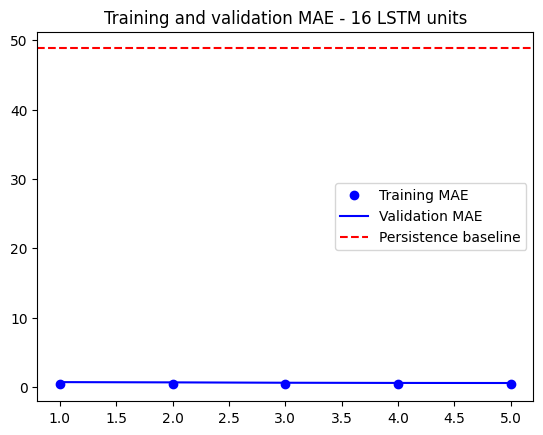

In [13]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [14]:
model.evaluate(test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6879 - mae: 1.1663


[1.7056893110275269, 1.1716934442520142]

### Using dropout to fight overfitting

In [15]:
inputs = keras.Input(shape=(12, 1))

x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=30,
                    validation_data=validation)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.5227 - mae: 0.5759 - val_loss: 0.7246 - val_mae: 0.6535
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2220 - mae: 0.3715 - val_loss: 0.6558 - val_mae: 0.6167
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2194 - mae: 0.3685 - val_loss: 0.5906 - val_mae: 0.5813
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2191 - mae: 0.3681 - val_loss: 0.5754 - val_mae: 0.5754
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2139 - mae: 0.3642 - val_loss: 0.5435 - val_mae: 0.5587
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2145 - mae: 0.3649 - val_loss: 0.5396 - val_mae: 0.5569
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2140 - mae: 0.3635 - val_loss: 0.5342 - val_mae: 0.5511
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2109 - mae: 0.3605 - val_loss: 0.5549 - val_mae: 0.5654
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.211

KeyboardInterrupt: 

In [ ]:
persistence_mae

0.19658639424505697

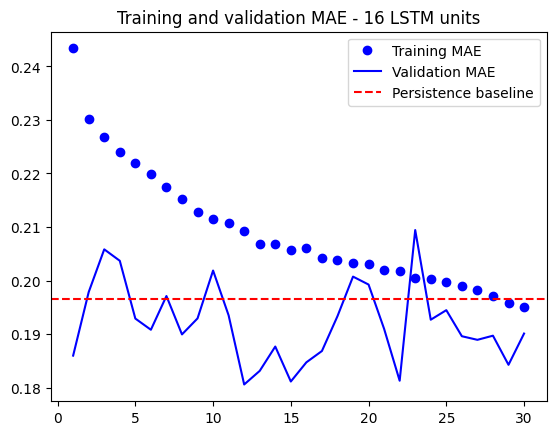

In [ ]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test)

3298/3298 [==============================] - 2s 695us/step - loss: 0.0482 - mae: 0.1788


[0.048175279051065445, 0.1788160502910614]

We have a model which outperforms the baseline and the non-dropout LSTM. 

In [ ]:
# Ok let's just deploy 

# TF Lite prefers the saved model format: https://www.tensorflow.org/lite/models/convert
# But normal saving prefers the .keras format https://www.tensorflow.org/guide/keras/serialization_and_saving
# And there's a bug with M1/M2 macs! https://github.com/keras-team/keras/issues/18278 


model.save('saved_models/regularised_lstm.keras')
model.save('saved_models/regularised_lstm_saved_model_format', save_format='tf')
model.save('saved_models/regularised_lstm_h5.h5', save_format='h5')


print(std)
print(mean)

temperature    2.30707
dtype: float64
temperature    22.981637
dtype: float64


/Users/dixonb01/.pyenv/versions/3.9.11/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
